# Modelo 2 Random Forest con todas las variables, con balanceo de la variable objetivo dentro del Random Forest y los hiperparámetros aplicados directamente al modelo

### Carga y división de datos

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Carga de datos
df_impagos = pd.read_csv('../Datos/Crudos/Loan_default.csv')
df_impagos.drop(columns=['LoanID'], inplace=True)
df_impagos.sample(5)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
212942,59,84107,146966,474,88,1,7.00,12,0.29,High School,Self-employed,Married,No,No,Auto,Yes,0
14604,29,98296,151338,330,81,4,10.95,36,0.66,PhD,Self-employed,Divorced,Yes,Yes,Business,No,0
192266,33,75789,33379,398,52,2,17.99,36,0.40,PhD,Self-employed,Single,No,No,Business,Yes,0
91409,54,114019,27425,388,89,4,6.77,24,0.39,High School,Part-time,Divorced,No,Yes,Education,No,0
18057,58,115292,203229,624,2,3,3.58,48,0.77,PhD,Self-employed,Divorced,No,Yes,Other,No,0


In [ ]:
# División de los datos
X = df_impagos.drop(columns=['Default'])
y = df_impagos.Default

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42)

### Creación de pipeline

In [4]:
# Dividir columnas categóricas
columnas_categoricas = X.select_dtypes(include='object').columns.to_list()

# Preprocesador con OneHotEncoder
preprocesador = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ], remainder='passthrough'
)

In [5]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=None, n_estimators=100, min_samples_split=5, min_samples_leaf=1))
    ]
)

In [6]:
# Entrenamiento
pipeline.fit(X_train, y_train)

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Education',
                                                   'EmploymentType',
                                                   'MaritalStatus',
                                                   'HasMortgage',
                                                   'HasDependents',
                                                   'LoanPurpose',
                                                   'HasCoSigner'])])),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=5,
                                        random_state=42))])

In [7]:
# Predicciones
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

### Evaluación del modelo

In [8]:
# Cálculo de accuracy train
train_accuracy = accuracy_score(y_train, y_train_pred)

# Cálculo de accuracy train
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Accuracy train:', train_accuracy)
print('Accuracy test:', test_accuracy)

Accuracy train: 0.9998097816965235
Accuracy test: 0.8851119378630637


In [9]:
# Reporte de clasificación
reporte = classification_report(y_test, y_test_pred)
print(reporte)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     67681
           1       0.60      0.04      0.08      8924

    accuracy                           0.89     76605
   macro avg       0.74      0.52      0.51     76605
weighted avg       0.85      0.89      0.84     76605



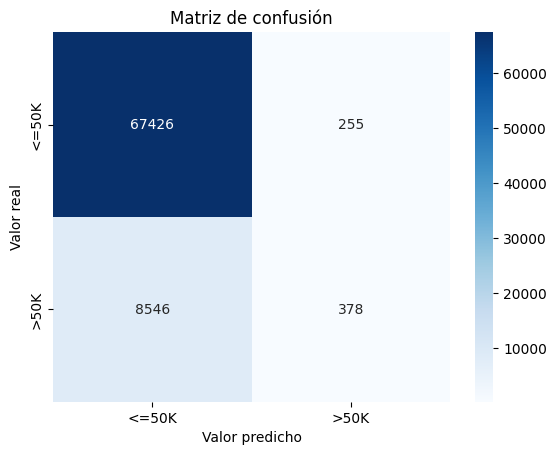

In [10]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_test_pred)
sns.heatmap(matriz_confusion, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'], cmap='Blues')
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show();

### Importancia de las variables

In [11]:
# Se calculan las importancias
importancias = pipeline.named_steps['modelo'].feature_importances_

# Se toman los nombres de las variables
nombres_onehot = pipeline.named_steps['preprocesamiento'].named_transformers_['onehot']
nombres_onehot = nombres_onehot.get_feature_names_out(columnas_categoricas)

nombres_passthrough = [col for col in X.columns if col not in columnas_categoricas]

# Se combinan los nombres de las columnas
nombres_columnas = np.concatenate([nombres_onehot, nombres_passthrough])

In [12]:
# Se crea el df con las importancias
df_importancias = pd.DataFrame({
    'variable' : nombres_columnas,
    'importancia' : importancias
}).sort_values(by=['variable', 'importancia'], ascending=False)

In [13]:
# Crear un diccionario para agrupar importancias
agrupadas = {}

# Agrupar OneHot por variable original
for cat in columnas_categoricas:
    columnas_relacionadas = [col for col in nombres_columnas if col.startswith(cat + "_")]
    importancia_total = df_importancias[df_importancias['variable'].isin(columnas_relacionadas)]['importancia'].sum()
    agrupadas[cat] = round(importancia_total, 2)

# Agregar variables numéricas (no categóricas)
for num in nombres_passthrough:
    importancia = df_importancias[df_importancias['variable'] == num]['importancia'].values[0]
    agrupadas[num] = round(importancia, 2)

# Convertir a DataFrame
df_agrupadas = pd.DataFrame.from_dict(agrupadas, orient='index', columns=['Importancia']) \
                           .sort_values(by='Importancia', ascending=False)

In [14]:
df_agrupadas

,Importancia
Age,0.13
Income,0.12
InterestRate,0.12
MonthsEmployed,0.10
LoanAmount,0.10
CreditScore,0.09
DTIRatio,0.08
LoanPurpose,0.05
EmploymentType,0.04
Education,0.04
